In [19]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
import Models 
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import random

import time
import os
import gc

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
train_npy_path =  './data/train/' #路径
test_npy_path =  './data/test/' 
shadow_npy_folder = './data/shadow/'
xml_path = './xml/xml/'
#lable_path = './label.npy'

model_path = './model/'+time_str
log_path = './log/'+  time_str


EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:1


In [21]:
test_Dataset = ecg_get_data.ECG_Dataset(test_npy_path,EcgChannles_num,EcgLength_num,xml_folder=xml_path)
train_Dataset = ecg_get_data.ECG_Dataset(train_npy_path,EcgChannles_num,EcgLength_num,shadow_npy_folder=shadow_npy_folder,xml_folder=xml_path)

In [22]:
length=len(train_Dataset)
train_size,validate_size=int(0.8*length),length-int(0.8*length)
#first param is data set to be saperated, the second is list stating how many sets we want it to be.
train_Dataset,valid_Dataset=torch.utils.data.random_split(train_Dataset,[train_size,validate_size])
print(train_Dataset,valid_Dataset)


<torch.utils.data.dataset.Subset object at 0x7f59039ad1d0> <torch.utils.data.dataset.Subset object at 0x7f59039ad910>


tensor(1)

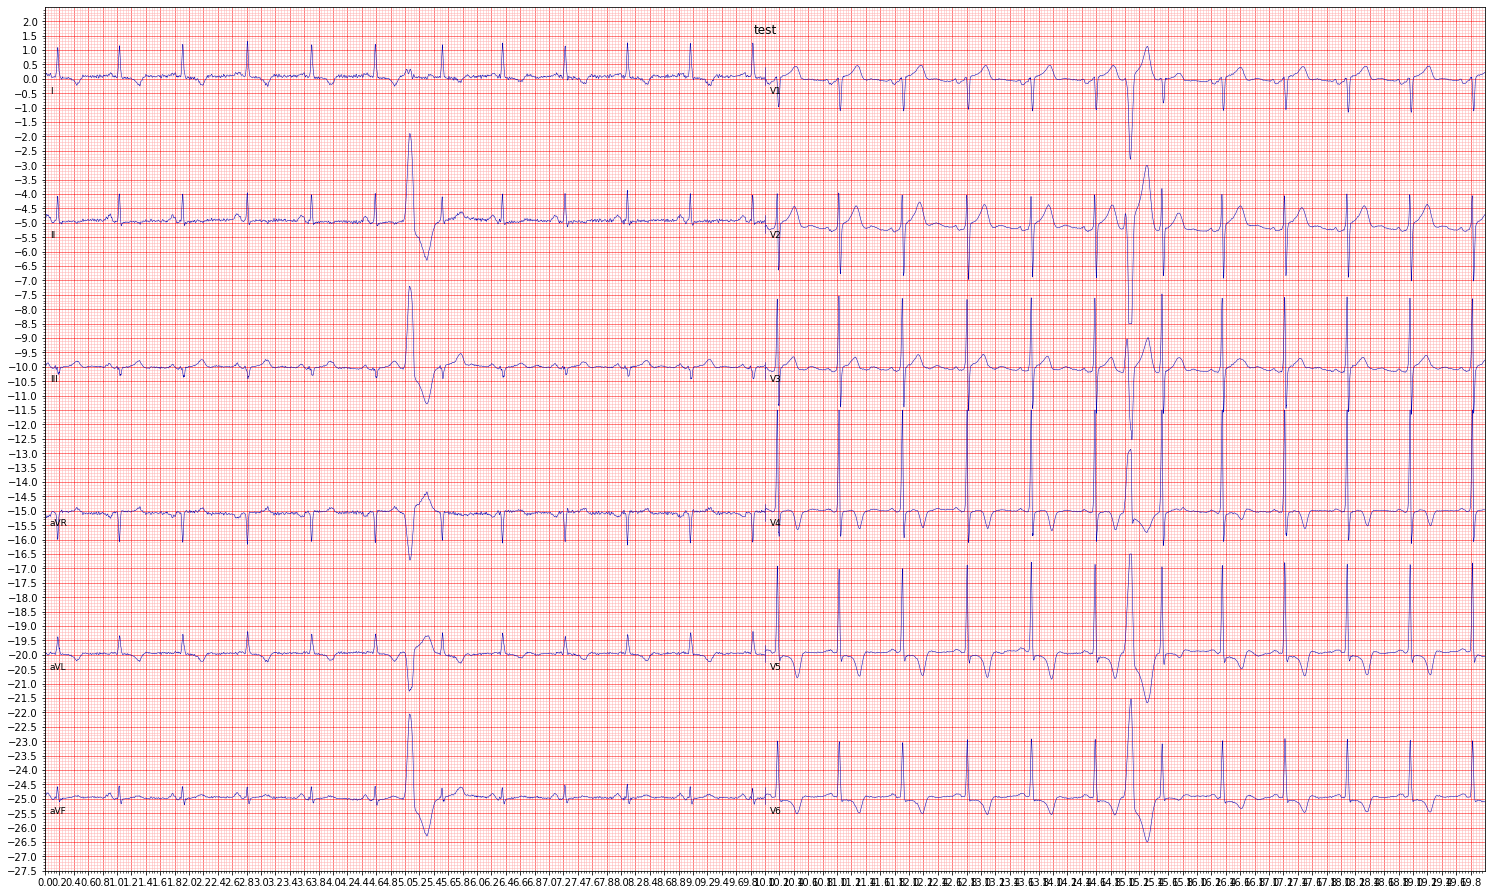

In [23]:
ECG,label = test_Dataset.__getitem__(12)
#inf,path = train_Dataset.get_basic_inf(55)
ecg_plot.plot(ECG*3.5, sample_rate = 500, title = "test",row_height= 10,show_grid=True,show_separate_line=True)
label
#ecg_plot.save_as_png(inf[1],'/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN//PNG_ECG/',dpi = 100)

## -----Old-----

In [ ]:
x = ecg_get_data.load_data(data_path,EcgChannles_num=EcgChannles_num,EcgLength_num=EcgLength_num)
y = ecg_get_data.load_label(lable_path)

In [ ]:
x = ecg_get_data.amplitude_limiting(x,2500)

In [ ]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,train_size=0.8,random_state = random_seed,shuffle = True,stratify=y)
gc.collect()
print("         HTN     NHTN ")
print("train: %5d   %5d" % (train_y.sum(),len(train_y)-train_y.sum()))
print("test : %5d   %5d" % (test_y.sum(),len(test_y)-test_y.sum()))

In [ ]:
train_x ,train_y = ecg_get_data.sliding_window(train_x ,train_y,2000,3)
test_x ,test_y = ecg_get_data.sliding_window(test_x ,test_y,2000,3)
print("         HTN     NHTN ")
print("train: %5d   %5d" % (train_y.sum(),len(train_y)-train_y.sum()))
print("test : %5d   %5d" % (test_y.sum(),len(test_y)-test_y.sum()))

## old

In [36]:
BATCH_SIZE = 256
FOLDS = 1
EPOCHS = 5000  
PATIENCE = 1000
LR = 0.01

In [37]:
from torch.utils.tensorboard import SummaryWriter   
os.makedirs(model_path, exist_ok=True)
writer = SummaryWriter(log_path)
from torchsummary import summary

In [38]:
torch.cuda.empty_cache()# 清空显卡cuda
#NET = [Models.resnet18(input_channels=12, inplanes=32, num_classes=2) for i in range(FOLDS)]
NET = [Models.channels_split_CNN() for i in range(FOLDS)]
print(summary(NET[0], (EcgChannles_num,5000), device="cpu"))
writer.add_graph(NET[0],torch.rand([1,EcgChannles_num,5000]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 5000]             176
       BatchNorm1d-2             [-1, 16, 5000]              32
              ReLU-3             [-1, 16, 5000]               0
         MaxPool1d-4             [-1, 16, 2500]               0
            Conv1d-5             [-1, 32, 2500]           2,560
       BatchNorm1d-6             [-1, 32, 2500]              64
              ReLU-7             [-1, 32, 2500]               0
         MaxPool1d-8             [-1, 32, 1250]               0
            Conv1d-9             [-1, 16, 5000]             176
      BatchNorm1d-10             [-1, 16, 5000]              32
             ReLU-11             [-1, 16, 5000]               0
        MaxPool1d-12             [-1, 16, 2500]               0
           Conv1d-13             [-1, 32, 2500]           2,560
      BatchNorm1d-14             [-1, 3

/workspace/data/Interpretable_HTN/self_attention.py:131: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim % 2 != 0:
/workspace/data/Interpretable_HTN/self_attention.py:135: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  i_matrix = torch.arange(dim//2, dtype=torch.float)
/workspace/data/Interpretable_HTN/self_attention.py:150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the da

In [39]:
from torch.optim.lr_scheduler import CosineAnnealingLR

for fold in range(FOLDS):
    
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0)
    #train_dataset,valid_dataset = get_k_fold_dataset(fold=int(fold+1),x = train_x,y=train_y,k=FOLDS,random_seed = random_seed)
    #valid_dataset  = ecg_get_data.load_numpy_dataset_to_tensor_dataset(test_x,test_y)
    #train_dataset =  ecg_get_data.load_numpy_dataset_to_tensor_dataset(train_x,train_y)
    train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=BATCH_SIZE, shuffle=True)

    NET[fold].to(DEVICE)
    optimizer  = torch.optim.Adadelta(NET[fold].parameters(), lr=LR,weight_decay=1e-1,eps=1e-3)  
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 200, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()   
    #等间隔调整学习率
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 24)
    best_loss = 3
    for epoch in range(1,EPOCHS):
        time_all=0
        start_time = time.time()
        train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # 训练模型
        #scheduler.step() # 学习率迭代

        time_all = time.time()-start_time
        validate_loss,validate_acc = test_model(valid_dataloader,criterion,NET[fold],DEVICE) # 测试模型
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)

        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - Val_loss: %.5f - Val_acc: %5f - T_Time: %.3f' %(epoch,train_loss,train_acc,validate_loss,validate_acc,time_all))
        print('当前学习率：%f' %optimizer.state_dict()['param_groups'][0]['lr'])

        if validate_loss < best_loss:
            best_loss = validate_loss
            print('Find better model in Epoch {0}, saving model.'.format(epoch))
            #torch.save(NET[fold],  model_path+'/best_model_' + str(fold) + '.pt')  # 保存最优模型
        else:
            scheduler.step() # 学习率迭代
        #是否满足早停法条件
        if(early_stopping(validate_loss,NET[fold])):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

- Epoch: 1 - Train_loss: 0.69463 - Train_acc: 0.48542 - Val_loss: 0.69331 - Val_acc: 0.500000 - T_Time: 9.579
当前学习率：0.010000
Find better model in Epoch 1, saving model.
Validation loss decreased (inf --> 0.693308).  Saving model ...
                    --------------------------------------------------

- Epoch: 2 - Train_loss: 0.69077 - Train_acc: 0.55130 - Val_loss: 0.69340 - Val_acc: 0.500000 - T_Time: 8.936
当前学习率：0.010000
EarlyStopping counter: 1 out of 1000

- Epoch: 3 - Train_loss: 0.69163 - Train_acc: 0.54245 - Val_loss: 0.69352 - Val_acc: 0.500000 - T_Time: 8.943
当前学习率：0.010000
EarlyStopping counter: 2 out of 1000

- Epoch: 4 - Train_loss: 0.69200 - Train_acc: 0.53620 - Val_loss: 0.69357 - Val_acc: 0.500000 - T_Time: 8.905
当前学习率：0.010000
EarlyStopping counter: 3 out of 1000

- Epoch: 5 - Train_loss: 0.68910 - Train_acc: 0.57865 - Val_loss: 0.69375 - Val_acc: 0.500000 - T_Time: 9.027
当前学习率：0.010000
EarlyStopping counter: 4 out of 1000

- Epoch: 6 - Train_loss: 0.69077 - Train_ac

In [ ]:
train_Dataset.__len__()

In [ ]:
test_Dataset.__len__()

In [ ]:
valid_Dataset.__len__()